## Importing libraries we'll need

In [1]:
from scipy.io import loadmat #input data for this is a matlab datafile. ew...
import pandas as pd
import numpy as np
import math
from sklearn import model_selection #this will be used to randomise the data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
%matplotlib inline

## Loading the file

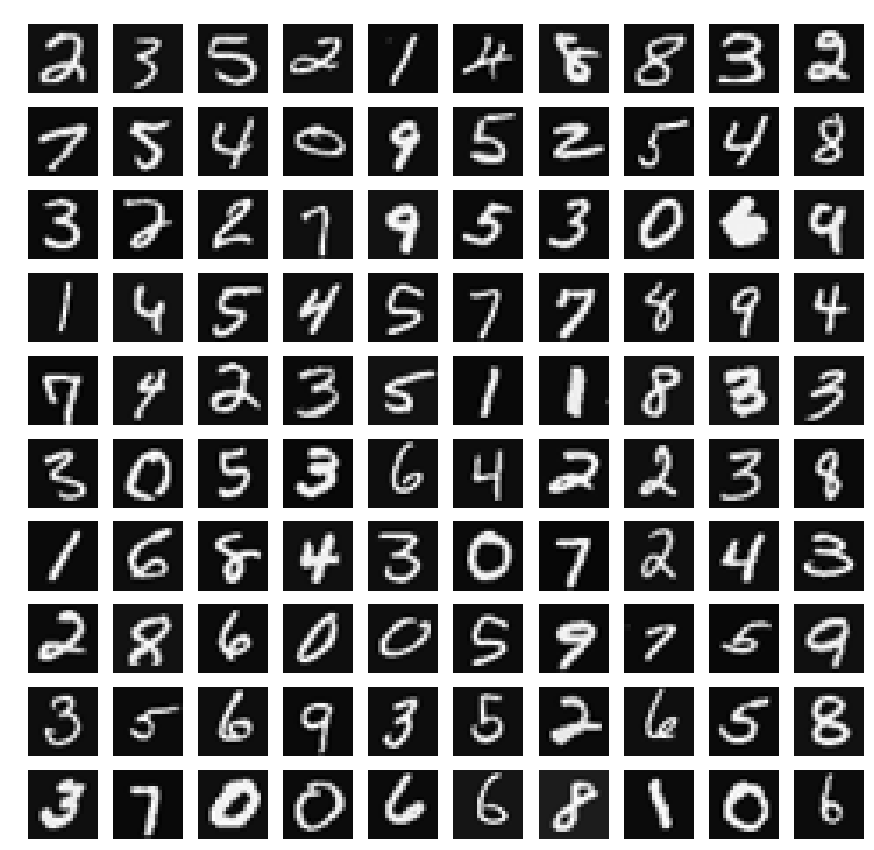

In [2]:
#loading our data
df = loadmat(r'P:\ENGINEERING\FPO\Digitalisation\1 FPO Projects\IIX Data Analytics\02-General presentations\Knowledge folder - preparation\Data Science Learning Framework\Machine Learning Posters\4 - Neural Networks\written_letters.mat') 

#plotting a random assortment of the data to show what we're working with: 20x20 pixel images, with a matrix of lightness values for each
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize = ((15,15))) #creating subplots to plot 100 images
for i in range(10): #for columns in the matrix
    for j in range(10): #for rows in the matrix
        plt.gray()
        #plotting randomly indexed imgs
        axs[i, j].matshow(df["X"][np.random.randint(low=0,high=4999)].reshape((20,20)).transpose())
        axs[i, j].axis("off")

## Formatting the data

In [3]:
#data is imported in dictionaries, so we'll extract the lists by calling the keys
X = df["X"] #This gives a list of lists, where every nested list contains 400 pixel brightness values for each image
y = df["y"].transpose()[0] #the y values are in an array of lists so we need to flatten it for easy indexing

for i in range(len(y)): #the label for 0 is listed as 10, this corrects it to 0
    if y[i] == 10:
        y[i] = 0

#splitting the data randomly into training/testing data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=101)

In [4]:
#formatting the target data into the correct format for the final layer of neurons
#for a target of 8, this changes the format from [8] to a column vector of form [0,0,0,0,0,0,0,0,1,0]
no_of_classes = 10

#for each picture, will make a list of 0s, except a 1 for the target value using boolean as integer operations, then reshape into a column vector
targets = [np.reshape(np.array([(y_train[i] == j).astype(int) for j in range(no_of_classes)]), (10,1)) for i in range(len(y_train))]
targets_test = [np.reshape(np.array([(y_test[i] == j).astype(int) for j in range(no_of_classes)]), (10,1)) for i in range(len(y_test))]

## The Network

In [5]:
class Network(object):

    def __init__(self, sizes):
        '''setting no. of layers, sizes of layers and generating weights and activation matrices on creation of network'''
        
        self.layers = len(sizes)
        self.sizes = sizes
        #weight matrix of each layer must have as many columns as present layer activations (+1 for bias) and as many rows as the next
        self.weights = [np.random.randn(i,j+1) for i,j in zip(sizes[1:],sizes[:-1])]
        
        #activations vector of each layer must have as many entries as activations for that layer, 
        #except for the last layer which only has the outputs (no bias feeding into next layer)
        #it must be set with ones instead of zeros since the biases won't be changed and must be non-zero!
        self.activations = [np.ones((i+1,1)) for i in sizes[:-1]] + [np.ones((sizes[-1],1))]
        
    def feed_fwd(self, X, tr_ex):
        '''feed forward algorithm that multiplies values through from the input to the output layer'''
        
        self.activations[0][:,0] = np.append(X[tr_ex],1) #sets initial layer as input data values
        for i in range(self.layers-1): #iterates through layers (forward propagation)
            #for a given layer, will set every activation entry except the bias as the outputs from the previous layer
            self.activations[i+1][:self.sizes[i+1]] = self.sigmoid(np.dot(self.weights[i],self.activations[i]))
            
        return self.activations[-1] #returns last layer of activations (network output)

    def cost_func(self, X, y, iteration):
        '''defines the cost (how wrong the algorithm is) at a given iteration'''
        self.cost[iteration] = -(float(1)/len(X))*np.sum(np.array([y[i]*np.log(nn.feed_fwd(X,i)) + (1-y[i])*np.log(1-nn.feed_fwd(X,i)) for i in range(len(X))]))
    
    def backprop(self, X, y, train_its):
        '''backpropagation algorithm, which trains the network'''
        
        alpha = 1 #setting the learning rate
        self.cost = np.zeros((train_its)) #list to append cost at each iteration, so we can plot and make sure decreasing
        for iteration in range(train_its): #iterating through training iterations (epochs)
            if float(iteration)*100/train_its % 5 == 0: #printing % complete if multiple of 5
                print("{}% complete".format(np.round(float(iteration)*100/train_its)))
                
            self.cost_func(X, y, iteration) #calulating cost function for a given iteration
            
            #setting a list of matrices for the changes to weights in each iteration
            DELTAS = [np.zeros((i,j+1)) for i,j in zip(self.sizes[1:],self.sizes[:-1])]
            
            for tr_idx, tr_ex in enumerate(X): #for each training example
                
                #setting a list of matrices to change the amount (for each training example) of change (for each training iteration) to weights
                deltas = [0 for i in range(self.layers)]
                #running feed_fwd for the networks current output of this training example (activations needed for backpropagation) 
                self.feed_fwd(X, tr_idx)
                
                for layer in range(self.layers)[::-1]: #iterating backward through layers
                    
                    #if its the final layer, set the delta (how wrong activations are), as difference between output and target
                    if layer == self.layers-1:
                        delta = self.activations[layer] - y[tr_idx]   
                    
                    #otherwise use equation to propagate error backward from layer before
                    else:
                        delta = np.dot(self.weights[layer].transpose(),delta[:self.sizes[layer+1]])*self.activations[layer]*(1-self.activations[layer])

                    deltas[layer] = delta #assign activation deltas for the layer to deltas list
                
                #add these deltas for this training example to the overall change for this iteration
                DELTAS = [DELTAS[i] + np.dot(deltas[i+1][:self.sizes[i+1]], self.activations[i].transpose()) for i in range(self.layers-1)]

            #subtract the overall change for this iteration from the weights, to complete iteration by creating new weight values
            self.weights = [self.weights[i] - (float(1)/len(X))*alpha*DELTAS[i] for i in range(len(self.weights))]

    def sigmoid(self, h_value):
        '''the sigmoid function, which normalises values to between 0 and 1'''
        return float(1)/(1+math.e**-h_value)

In [6]:
#defining our network, with the sizes of each layer given (first must be 400 for each pixel, last must be 10 for each digit val)
nn = Network([400, 64, 64, 10])

In [7]:
training_its = 1000 #setting number of training iterations
nn.backprop(X_train, targets, training_its) #training the network

#saving the network to the file directory, so we don't have to train it every time
with open ('NeuralNet.pickle','wb') as f:
    pickle.dump(nn, f)

0.0% complete
5.0% complete
10.0% complete
15.0% complete
20.0% complete
25.0% complete
30.0% complete
35.0% complete
40.0% complete
45.0% complete
50.0% complete
55.0% complete
60.0% complete
65.0% complete
70.0% complete
75.0% complete
80.0% complete
85.0% complete
90.0% complete
95.0% complete


In [ ]:
#loading a network from a previously saved file (no need to do this if you just trained it)
pickle_in = open('NeuralNet.pickle','rb')
nn = pickle.load(pickle_in)

## Checking the cost

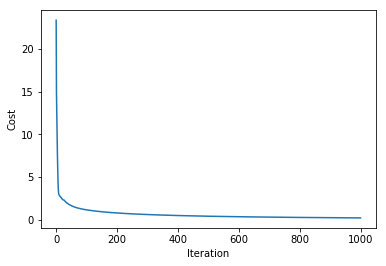

In [8]:
plt.plot(range(training_its),nn.cost) #plotting iteration vs. cost (to see how it decreases with training iterations)
plt.xlabel("Iteration")
plt.ylabel("Cost")

## An example output

Prediction, Actual: 1, 1

Final Layer Activations:
[[  1.59522117e-05]
 [  9.98240082e-01]
 [  3.77807477e-03]
 [  1.38752059e-03]
 [  9.61768184e-05]
 [  1.98965809e-03]
 [  1.88248720e-04]
 [  1.62335076e-03]
 [  1.79327814e-04]
 [  2.58127485e-06]]


(-0.5, 19.5, 19.5, -0.5)

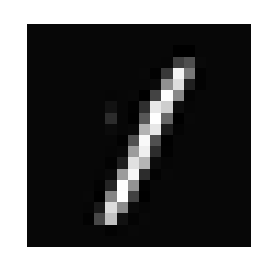

In [9]:
index = 620 #this number can be changed to anything between 0 and 1500 to test different examples

#predicting digit value by putting input data through network with feed_fwd function, then indexing y_test for actual value
print("Prediction, Actual: {}, {}".format(np.argmax(nn.feed_fwd(X_test, index)), y_test[index]))
print()
print("Final Layer Activations:")
print(nn.feed_fwd(X_test, index))

plt.gray()
plt.matshow(X_test[index].reshape((20,20)).transpose())
plt.axis("off")

## Results

In [10]:
#calculating the number of correctly assigned values in the test data
df = pd.DataFrame({"actual":y_test, #adding actual values of each digit in test data to dataframe
                   #adding predicted values, by applying feed_fwd and taking max output
                   "predicted":[np.argmax(nn.feed_fwd(X_test, iteration)) for iteration in range(len(X_test))]
                  })

correct = len(df[df["actual"] == df["predicted"]]) #length of df where actual = predicted is number of correctly estimated digits
fraction = float(correct)/len(df) #divide by total digits in test data for % correct
print("{}% correctly assigned".format(np.round(fraction*100,2)))

90.53% correctly assigned


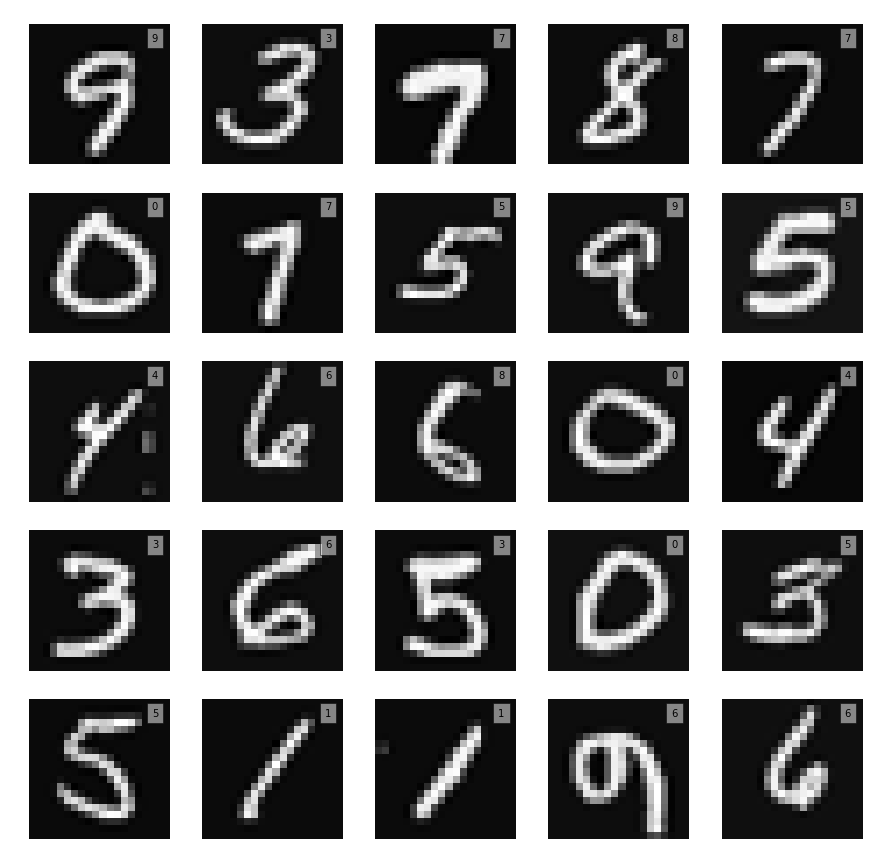

In [11]:
#generating a random sample of images and their predicted values, for some insight into how the network thinks
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize = ((15,15))) #creating subplots to plot 100 images
for i in range(5): #for columns in the matrix
    for j in range(5): #for rows in the matrix
        index = np.random.randint(low=0,high=1499) #generate a random index
        plt.gray()
        #plotting randomly indexed imgs
        axs[i, j].matshow(X_test[index].reshape((20,20)).transpose())
        axs[i, j].axis("off")
        #labelling the predicted value for each picture
        axs[i, j].text(17, 2, df["predicted"][index],
                       bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})
plt.savefig("estimated_numbers.png",dpi = 200)